#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [1]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

Read the spectral data

In [2]:
df = pd.read_csv("../data/400-1800_with_raw_scaled_surface_pagerank.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


#### **Select the chosen cleaning parameters then run the functions**

In [4]:
df.groupby('Status')['PageRank'].std()

Status
Hyperglycemia    0.528157
Hypoglycemia     0.478400
Normal           0.481107
Name: PageRank, dtype: float64

#### **Here is an example on 1 Spectra**

In [5]:
# Optuna Outlier Parameters
pagerank_cutoff = 0.90246099916895
despike_ma = 57
despike_threshold = 3.75
lam = 10 ** 11
p = 0.074
# window_size = 51
# poly_order = 3

#### **Here is an example on 1 Spectra**

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

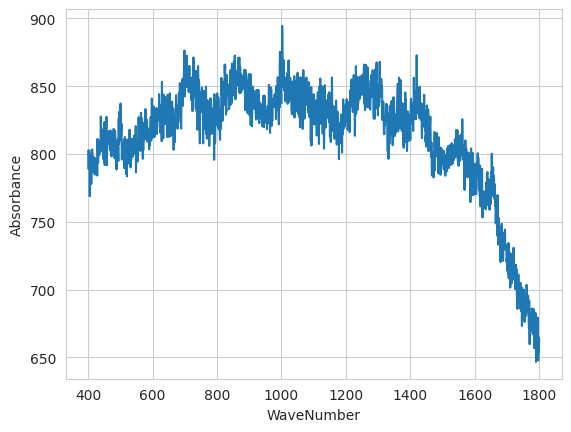

In [6]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

Despike

/tmp/ipykernel_9819/250951349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

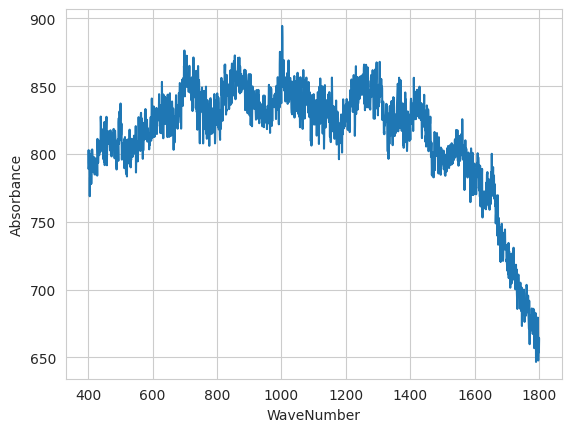

In [7]:
sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

Baseline Correction

/tmp/ipykernel_9819/2601916869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


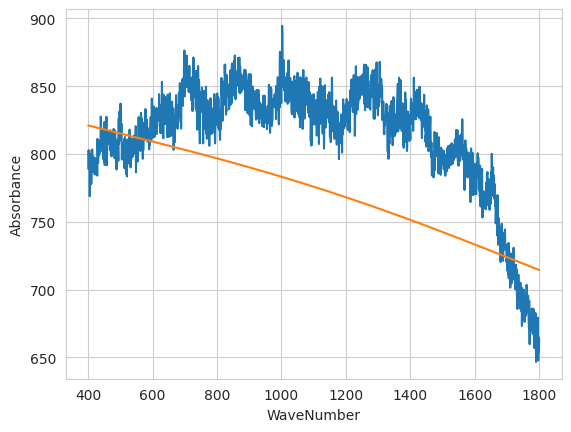

/tmp/ipykernel_9819/2601916869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

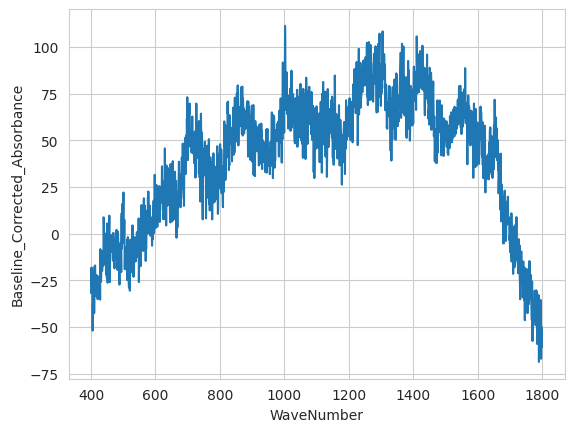

In [8]:
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)
plt.show()

# Subtract the baseline
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Scale the spectra

/tmp/ipykernel_9819/3447061085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))


<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

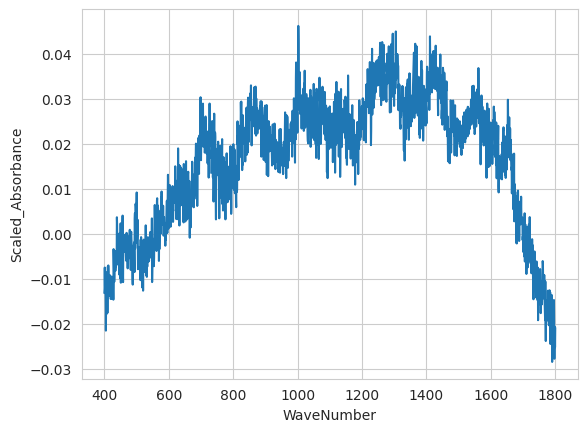

In [9]:
sample['Scaled_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)

In [10]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [11]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

In [12]:
df['Absorbance'] = df['Absorbance'] - df['Baseline']

In [13]:
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [14]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [15]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,Baseline
0,201210-1-00,293,400.22778,-0.001247,201210-1,Normal,0.610024,1769.569028
1,201210-1-00,294,400.91116,0.001740,201210-1,Normal,0.610024,1769.330009
2,201210-1-00,295,401.59454,-0.000019,201210-1,Normal,0.610024,1769.090991
3,201210-1-00,296,402.27789,-0.003967,201210-1,Normal,0.610024,1768.851972
4,201210-1-00,297,402.96127,-0.003110,201210-1,Normal,0.610024,1768.612953
...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-0.016926,210526-3,Hyperglycemia,1.201164,1753.639314
6239201,210526-3-09,2338,1797.72200,-0.014938,210526-3,Hyperglycemia,1.201164,1753.341720
6239202,210526-3-09,2339,1798.40550,-0.014875,210526-3,Hyperglycemia,1.201164,1753.044127
6239203,210526-3-09,2340,1799.08890,-0.013774,210526-3,Hyperglycemia,1.201164,1752.746533


In [16]:
df['SurID'].unique()

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210407-1',
       '210407-2', '210414-1', '210414-3', '210414-2', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

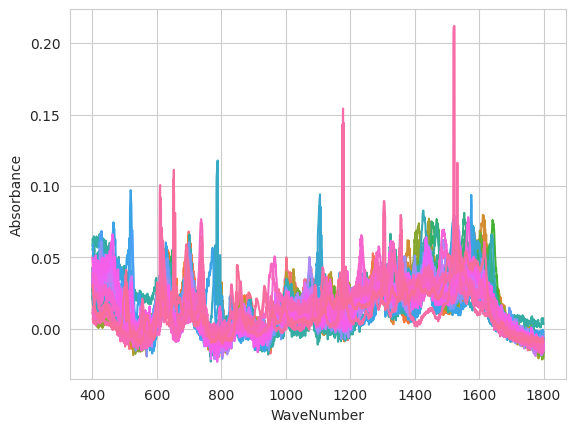

In [17]:
surface = df[df['SurID'] == '210303-1']
sns.lineplot(x="WaveNumber", y="Absorbance", data=surface, hue='SpecID', legend=False)

In [18]:
remaining_df = surface[surface['PageRank'] > pagerank_cutoff]
droped_df = surface[surface['PageRank'] <= pagerank_cutoff]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

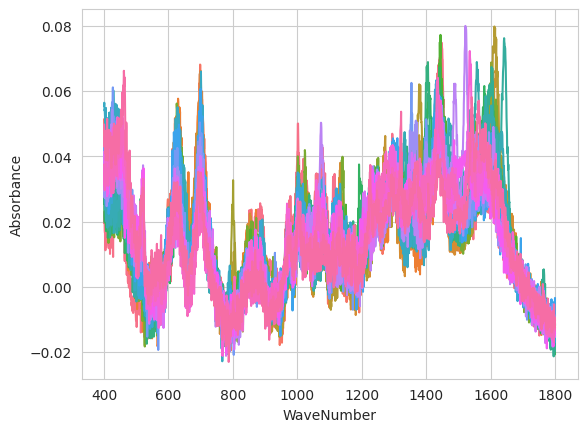

In [19]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=remaining_df, hue='SpecID', legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

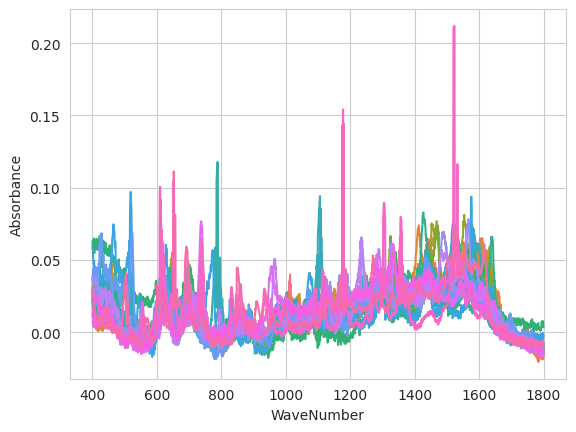

In [20]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=droped_df, hue='SpecID', legend=False)

Filter the dataset by pagerank.

In [21]:
df = df[df['PageRank'] > pagerank_cutoff]

In [22]:
len(df.groupby('SpecID'))

1783

In [23]:
df.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    502
Hypoglycemia     653
Normal           628
Name: SpecID, dtype: int64

In [24]:
df.groupby('Status')['SurID'].nunique()

Status
Hyperglycemia    19
Hypoglycemia     22
Normal           22
Name: SurID, dtype: int64

**Select the Most Effective Features**

In [25]:
selected_features_df = pd.read_csv("../../data/selected_features.csv")
selected_features_df = selected_features_df.rename(columns={"Selected Features" : "WaveNumber"})
selected_features_df

,WaveNumber
0,439.86331
1,507.51709
2,514.35077
3,517.76764
4,520.50116
5,633.94080
6,646.24146
7,659.90887
8,689.29382
9,728.24603


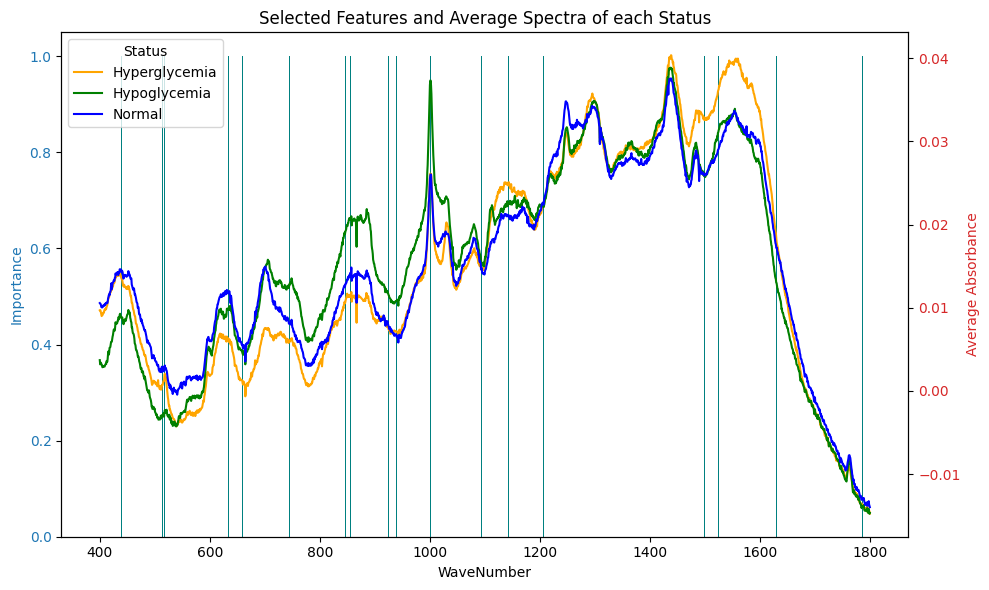

In [26]:
import matplotlib.style as style

# Use the default Matplotlib style
style.use('default')

# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['teal'] * len(selected_features_df['WaveNumber'])
ax1.bar(selected_features_df['WaveNumber'], 1, color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Selected Features and Average Spectra of each Status')

# # Show the plot
plt.tight_layout()
plt.show()

In [27]:
def evaluate_model(df, model):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Chose the selected features
    X = X.loc[:, X.columns.isin(selected_features_df['WaveNumber'])]
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    # Cross Validate
    scores = cross_validate(model, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [28]:
rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=78)
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

evaluate_model(wavelength_df, rf)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier Cross-Validation Accuracy: 0.7354 +/- 0.1151
RandomForestClassifier Cross-Validation Precision: 0.7076 +/- 0.0882
RandomForestClassifier Cross-Validation Recall: 0.7069 +/- 0.1078
RandomForestClassifier Cross-Validation F1-Score: 0.6827 +/- 0.1191


**Evalutate By Class**

In [29]:
def evaluate_model_by_class(df, model):
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Chose the selected features
    X = X.loc[:, X.columns.isin(selected_features_df['WaveNumber'])]
    
    # Get unique class names from the 'y' dataset
    class_names = y.unique()
    
    cv = GroupKFold(n_splits=10)

    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")

In [30]:
evaluate_model_by_class(wavelength_df, rf)

RandomForestClassifier Cross-Validation Accuracy: 0.7354 +/- 0.1151

Normal Precision: 0.7118 +/- 0.2155
Normal Recall: 0.6568 +/- 0.2639
Normal F1-Score: 0.6442 +/- 0.2272

Hyperglycemia Precision: 0.6081 +/- 0.2398
Hyperglycemia Recall: 0.6624 +/- 0.2587
Hyperglycemia F1-Score: 0.6253 +/- 0.2336

Hypoglycemia Precision: 0.8030 +/- 0.2009
Hypoglycemia Recall: 0.8014 +/- 0.1222
Hypoglycemia F1-Score: 0.7784 +/- 0.1315



**Use Spectra Predictions to Predict the Surface**

In [31]:
def evaluate_and_predict_surface_status(df, model):
    
    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Chose the selected features
    X = X.loc[:, X.columns.isin(selected_features_df['WaveNumber'])]
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # DataFrame to store the actual and predicted status for each spectrum
    predictions_df = pd.DataFrame(columns=['SurID', 'ActualStatus', 'PredictedStatus'])

    # Iterating over each fold
    for train_index, test_index in cv.split(X, y, groups=groups):
        # Splitting the dataset into the current train and test set
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_test = groups.iloc[test_index]
        
        # Fitting the model on the training set
        model.fit(X_train, y_train)

        # Predicting the status for the test set
        y_pred = model.predict(X_test)

        # Appending the SurID, actual, and predicted status to the predictions DataFrame
        fold_predictions = pd.DataFrame({
            'SurID': groups_test.values,
            'ActualStatus': y_test.values,
            'PredictedStatus': y_pred
        })
        predictions_df = pd.concat([predictions_df, fold_predictions], ignore_index=True)

    # Return the most common prediction of each spectra within the surface
    return predictions_df.groupby('SurID').agg(lambda x: x.mode()[0]).reset_index()
    

In [32]:
surface_predictions = evaluate_and_predict_surface_status(wavelength_df, rf)
surface_predictions

,SurID,ActualStatus,PredictedStatus
0,201210-1,Normal,Normal
1,201210-2,Normal,Hypoglycemia
2,210114-1,Normal,Normal
3,210114-2,Normal,Normal
4,210120-1,Hyperglycemia,Normal
...,...,...,...
58,210519-3,Hyperglycemia,Hyperglycemia
59,210524-1,Hypoglycemia,Hyperglycemia
60,210526-1,Hyperglycemia,Hyperglycemia
61,210526-2,Hyperglycemia,Normal


In [33]:
print(classification_report(surface_predictions['ActualStatus'], surface_predictions['PredictedStatus']))

               precision    recall  f1-score   support

Hyperglycemia       0.74      0.74      0.74        19
 Hypoglycemia       0.71      0.77      0.74        22
       Normal       0.75      0.68      0.71        22

     accuracy                           0.73        63
    macro avg       0.73      0.73      0.73        63
 weighted avg       0.73      0.73      0.73        63

